
# **Proyecto Final Integrador – Ciencia de Datos**

**Carpetas de trabajo (Colab):**
- Entrada: **`/content/datasets`**  (se crea automáticamente; alias: `/datasets`)
- Salida: **`/content/datasets/outputs`**

**Formato de exportación:** CSV \


## 0) Primeros pasos, preparar el entorno
**Objetivo:** importar librerías, fijar opciones y preparar carpetas.

**Qué hace:**
- Importar librerias y crear directorios dentro del entorno de trabajo

In [1]:

import os, warnings, shutil, pathlib
from datetime import datetime
import numpy as np, pandas as pd
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", 120)
pd.set_option("display.width", 140)

def running_in_colab():
    try:
        import google.colab
        return True
    except Exception:
        return False

BASE_DIR    = "/content" if running_in_colab() else "."
DATA_DIR    = os.path.join(BASE_DIR, "datasets")
OUTPUTS_DIR = os.path.join(DATA_DIR, "outputs")

os.makedirs(OUTPUTS_DIR, exist_ok=True)

if running_in_colab() and not os.path.exists("/datasets"):
    os.symlink(DATA_DIR, "/datasets")

print("Working dir:", os.getcwd())
print("BASE_DIR   :", BASE_DIR)
print("DATA_DIR   :", DATA_DIR)
print("OUTPUTS    :", OUTPUTS_DIR)
print("Symlink /datasets ->", os.path.realpath("/datasets") if os.path.exists("/datasets") else "no creado")


# Librerías adicionales para visualización avanzada
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

sns.set(style="whitegrid")


Working dir: /content
BASE_DIR   : /content
DATA_DIR   : /content/datasets
OUTPUTS    : /content/datasets/outputs
Symlink /datasets -> /content/datasets



## 1) Cargar y ubicar archivos de dataset en `/content/datasets`
**Objetivo:** cargar `ventas.csv`, `clientes.csv`, `marketing.csv` estén en **`/content/datasets`**.


In [2]:

VENTAS_CSV    = os.path.join(DATA_DIR, "ventas.csv")
CLIENTES_CSV  = os.path.join(DATA_DIR, "clientes.csv")
MARKETING_CSV = os.path.join(DATA_DIR, "marketing.csv")

def _ensure_files():
    expected = {"ventas.csv": VENTAS_CSV, "clientes.csv": CLIENTES_CSV, "marketing.csv": MARKETING_CSV}
    search_dirs = [DATA_DIR, "./datasets", os.getcwd(), "/datasets"]
    for name, dest in expected.items():
        if os.path.exists(dest):
            continue
        found = None
        for d in search_dirs:
            cand = os.path.join(d, name)
            if os.path.exists(cand):
                found = cand; break
        if found:
            shutil.move(found, dest)
            print(f"Movido {found} → {dest}")
    missing = [n for n,p in expected.items() if not os.path.exists(p)]
    if missing:
        print("Faltan archivos:", missing)
        if running_in_colab():
            try:
                from google.colab import files  # type: ignore
                print("Abrir diálogo de subida…")
                uploaded = files.upload()
                for fname in uploaded.keys():
                    src = fname
                    dest = os.path.join(DATA_DIR, os.path.basename(fname))
                    shutil.move(src, dest)
                    print(f" Subido y movido a {dest}")
            except Exception as e:
                print("No se pudo abrir files.upload(). Copiá manualmente a:", DATA_DIR)
        else:
            print("No estás en Colab. Copiá manualmente a:", DATA_DIR)

_ensure_files()
print("Contenido de", DATA_DIR, ":\n", os.listdir(DATA_DIR))


Faltan archivos: ['ventas.csv', 'clientes.csv', 'marketing.csv']
Abrir diálogo de subida…


Saving clientes.csv to clientes.csv
Saving marketing.csv to marketing.csv
Saving ventas.csv to ventas.csv
 Subido y movido a /content/datasets/clientes.csv
 Subido y movido a /content/datasets/marketing.csv
 Subido y movido a /content/datasets/ventas.csv
Contenido de /content/datasets :
 ['outputs', 'marketing.csv', 'ventas.csv', 'clientes.csv']



## 2) Lectura a dataframes y chequeos
**Objetivo:** leer los CSV y revisar la estructura.

**Pasos:**
- Cargar `ventas_raw`, `clientes`, `marketing`.
- Mostrar `shape`, `.head(3)` y `.info()`.


In [3]:

def _read_csv_smart(path, **kwargs):
    encodings = [kwargs.pop("encoding", None), "utf-8", "latin-1", "cp1252"]
    last_err = None
    for enc in encodings:
        try:
            return pd.read_csv(path, encoding=enc, **kwargs)
        except Exception as e:
            last_err = e
            continue
    raise last_err

ventas_raw = _read_csv_smart(VENTAS_CSV)
clientes    = _read_csv_smart(CLIENTES_CSV)
marketing   = _read_csv_smart(MARKETING_CSV)

print("Shapes:", ventas_raw.shape, clientes.shape, marketing.shape)
display(ventas_raw.head(3)); display(clientes.head(3)); display(marketing.head(3))
print("\n=== INFO INICIAL VENTAS ==="); print(ventas_raw.info())
print("\n=== INFO INICIAL CLIENTES ==="); print(clientes.info())
print("\n=== INFO INICIAL MARKETING ==="); print(marketing.info())


Shapes: (3035, 6) (567, 5) (90, 6)


,id_venta,producto,precio,cantidad,fecha_venta,categoria
0,792,Cuadro decorativo,$69.94,5.0,02/01/2024,Decoración
1,811,Lámpara de mesa,$105.10,5.0,02/01/2024,Decoración
2,1156,Secadora,$97.96,3.0,02/01/2024,Electrodomésticos


,id_cliente,nombre,edad,ciudad,ingresos
0,1,Aloysia Screase,44,Mar del Plata,42294.68
1,2,Kristina Scaplehorn,25,Posadas,24735.04
2,3,Filip Castagne,50,Resistencia,35744.85


,id_campanha,producto,canal,costo,fecha_inicio,fecha_fin
0,74,Adorno de pared,TV,4.81,20/03/2024,03/05/2024
1,12,Tablet,RRSS,3.40,26/03/2024,13/05/2024
2,32,Lámpara de mesa,Email,5.54,28/03/2024,20/04/2024



=== INFO INICIAL VENTAS ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3035 entries, 0 to 3034
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id_venta     3035 non-null   int64  
 1   producto     3035 non-null   object 
 2   precio       3033 non-null   object 
 3   cantidad     3033 non-null   float64
 4   fecha_venta  3035 non-null   object 
 5   categoria    3035 non-null   object 
dtypes: float64(1), int64(1), object(4)
memory usage: 142.4+ KB
None

=== INFO INICIAL CLIENTES ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 567 entries, 0 to 566
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id_cliente  567 non-null    int64  
 1   nombre      567 non-null    object 
 2   edad        567 non-null    int64  
 3   ciudad      567 non-null    object 
 4   ingresos    567 non-null    float64
dtypes: float64(1), int64(2), object(2


## 3) Estructuras de datos (listas/dicts)
**Objetivo:** demostrar el uso de listas y diccionarios con filas de ventas.

**Pasos:**
- Tomar 5 filas y construir una **lista de diccionarios** con `producto`, `precio`, `cantidad`.


In [4]:

# ==== 3) Estructuras de Datos ====
ejemplo_estructura = [
    {"producto": row["producto"], "precio": row["precio"], "cantidad": row["cantidad"]}
    for _, row in ventas_raw.head(5).iterrows()
]
print("Estructura ejemplo (primeras 5 filas):")
for item in ejemplo_estructura:
    print(item)


Estructura ejemplo (primeras 5 filas):
{'producto': 'Cuadro decorativo', 'precio': '$69.94', 'cantidad': 5.0}
{'producto': 'Lámpara de mesa', 'precio': '$105.10', 'cantidad': 5.0}
{'producto': 'Secadora', 'precio': '$97.96', 'cantidad': 3.0}
{'producto': 'Heladera', 'precio': '$114.35', 'cantidad': 8.0}
{'producto': 'Secadora', 'precio': '$106.21', 'cantidad': 4.0}



## 4) Calidad inicial (nulos/duplicados)
**Objetivo:** medir estado inicial para comparar luego de la limpieza.


In [5]:


def quality_report(df, name):
    rep = {"rows": len(df), "cols": df.shape[1], "nulls_por_col": df.isna().sum().to_dict(), "dups_filas": int(df.duplicated().sum())}
    print(f"\n--- Calidad inicial: {name} ---")
    print("Filas, Columnas:", rep["rows"], rep["cols"])
    print("Duplicados (filas):", rep["dups_filas"])
    print("Nulos por columna:")
    for k, v in rep["nulls_por_col"].items():
        print(f"  - {k}: {v}")
    return rep

_ = quality_report(ventas_raw, "ventas_raw")
_ = quality_report(clientes, "clientes")
_ = quality_report(marketing, "marketing")



--- Calidad inicial: ventas_raw ---
Filas, Columnas: 3035 6
Duplicados (filas): 35
Nulos por columna:
  - id_venta: 0
  - producto: 0
  - precio: 2
  - cantidad: 2
  - fecha_venta: 0
  - categoria: 0

--- Calidad inicial: clientes ---
Filas, Columnas: 567 5
Duplicados (filas): 0
Nulos por columna:
  - id_cliente: 0
  - nombre: 0
  - edad: 0
  - ciudad: 0
  - ingresos: 0

--- Calidad inicial: marketing ---
Filas, Columnas: 90 6
Duplicados (filas): 0
Nulos por columna:
  - id_campanha: 0
  - producto: 0
  - canal: 0
  - costo: 0
  - fecha_inicio: 0
  - fecha_fin: 0



## 5) Limpieza y estandarización
**Objetivo:** dejar `ventas` analizable.

**Pasos:**
1. **Precio** → quitar símbolos y convertir a numérico (`precio_num`).
2. **Fecha** → `fecha_venta` a `datetime` (día/mes/año).
3. **Duplicados** → eliminar por `id_venta` si existe; si no, por fila.
4. **Imputación** → completar `precio_num` y `cantidad` con **mediana por `producto`**.
5. **Descartar** filas aún inválidas (precio, cantidad o fecha nulos).
6. **Derivar** `ingreso` = `precio_num` × `cantidad`.


In [6]:

ventas = ventas_raw.copy()

def parse_precio(x):
    if pd.isna(x):
        return np.nan
    if isinstance(x, (int, float)):
        return float(x)
    x = str(x).replace("$", "").replace(",", "").strip()
    try:
        return float(x)
    except:
        return np.nan

ventas["precio_num"] = ventas["precio"].apply(parse_precio)
ventas["fecha_venta"] = pd.to_datetime(ventas["fecha_venta"], dayfirst=True, errors="coerce")

if "id_venta" in ventas.columns:
    ventas = ventas.drop_duplicates(subset=["id_venta"])
else:
    ventas = ventas.drop_duplicates()

for col in ["precio_num", "cantidad"]:
    if col in ventas.columns:
        ventas[col] = ventas.groupby("producto")[col].transform(lambda s: s.fillna(s.median()))

ventas = ventas.dropna(subset=["precio_num", "cantidad", "fecha_venta"])
ventas["ingreso"] = ventas["precio_num"] * ventas["cantidad"]

print("Limpieza realizada. Shape final ventas:", ventas.shape)
display(ventas.head(3))


Limpieza realizada. Shape final ventas: (3000, 8)


,id_venta,producto,precio,cantidad,fecha_venta,categoria,precio_num,ingreso
0,792,Cuadro decorativo,$69.94,5.0,2024-01-02,Decoración,69.94,349.70
1,811,Lámpara de mesa,$105.10,5.0,2024-01-02,Decoración,105.10,525.50
2,1156,Secadora,$97.96,3.0,2024-01-02,Electrodomésticos,97.96,293.88



## 6) Calcular ventas mensuales
**Objetivo:** calcular ventas por mes y graficar.

**Pasos:** derivar `anio_mes`, agregar ingresos y cantidad, calcular `ventas_netas_con_iva` y graficar.


,anio_mes,ventas_brutas,qty,ventas_netas_con_iva
0,2024-01,130539.94,1754.0,157953.3274
1,2024-02,118672.44,1607.0,143593.6524
2,2024-03,136779.15,1792.0,165502.7715
3,2024-04,128430.69,1715.0,155401.1349
4,2024-05,143727.25,1812.0,173909.9725
5,2024-06,108480.17,1426.0,131261.0057
6,2024-07,116229.97,1547.0,140638.2637
7,2024-08,119680.15,1614.0,144812.9815
8,2024-09,115787.85,1576.0,140103.2985
9,2024-10,112117.13,1458.0,135661.7273


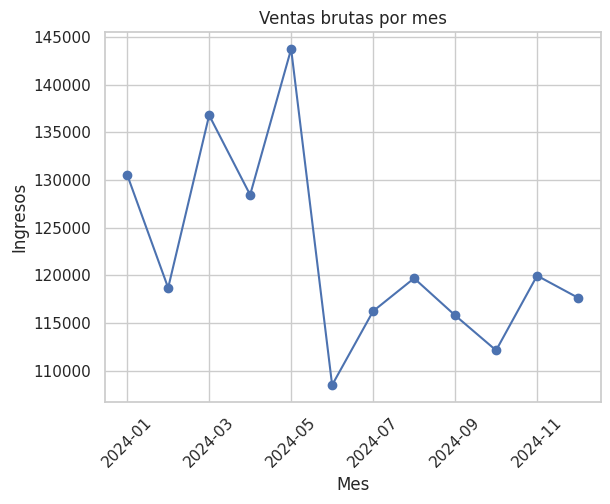

In [7]:

IVA = 0.21; DESC = 0.00
ventas["anio_mes"] = ventas["fecha_venta"].dt.to_period("M").astype(str)
ventas_mensuales = ventas.groupby("anio_mes", as_index=False).agg(
    ventas_brutas=("ingreso", "sum"),
    qty=("cantidad", "sum")
)
ventas_mensuales["ventas_netas_con_iva"] = ventas_mensuales["ventas_brutas"] * (1 + IVA) * (1 - DESC)
display(ventas_mensuales)

plt.figure(); ventas_mensuales.set_index("anio_mes")["ventas_brutas"].plot(marker="o")
plt.title("Ventas brutas por mes"); plt.xlabel("Mes"); plt.ylabel("Ingresos"); plt.xticks(rotation=45); plt.grid(True); plt.show()



## 7) EDA inicial
**Objetivo:** entender mix por **categoría** y **producto** (top 15).


Ingresos por categoría:


,categoria,ingreso
1,Electrodomésticos,505299.63
2,Electrónica,483113.51
0,Decoración,479615.33


Top 15 productos por ingreso:


,producto,ingreso
19,Lámpara de mesa,82276.38
3,Auriculares,74175.58
20,Microondas,72562.89
5,Cafetera,59607.31
9,Cuadro decorativo,54297.60
27,Smartphone,54132.44
25,Secadora,52115.45
16,Jarrón decorativo,51130.88
4,Batidora,50979.20
24,Rincón de plantas,50456.45


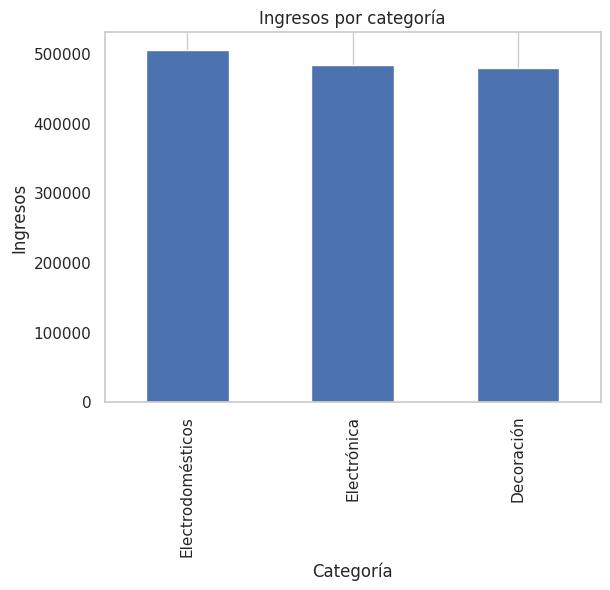

In [8]:

# ==== 7) EDA ====
cat_ingresos = ventas.groupby("categoria", as_index=False)["ingreso"].sum().sort_values("ingreso", ascending=False)
top_prod     = ventas.groupby("producto", as_index=False)["ingreso"].sum().sort_values("ingreso", ascending=False).head(15)
print("Ingresos por categoría:"); display(cat_ingresos)
print("Top 15 productos por ingreso:"); display(top_prod)

plt.figure(); cat_ingresos.set_index("categoria")["ingreso"].plot(kind="bar"); plt.title("Ingresos por categoría"); plt.xlabel("Categoría"); plt.ylabel("Ingresos"); plt.grid(axis="y"); plt.show()



## 8) Transformación: productos de alto rendimiento (p75)
**Objetivo:** detectar productos top por ingresos y exportar.


In [9]:

resumen_prod = ventas.groupby("producto", as_index=False).agg(
    ingresos=("ingreso", "sum"),
    unidades=("cantidad", "sum")
).sort_values("ingresos", ascending=False)

umbral = resumen_prod["ingresos"].quantile(0.75)
alto_rend = resumen_prod[resumen_prod["ingresos"] >= umbral].reset_index(drop=True)

print(f"Umbral (p75) de ingresos: {umbral:,.2f}")
display(alto_rend)

out1 = os.path.join(OUTPUTS_DIR, "productos_alto_rendimiento.csv")
alto_rend.to_csv(out1, index=False, encoding="utf-8-sig")
print("Guardado:", out1, "(utf-8-sig)")


Umbral (p75) de ingresos: 51,092.96


,producto,ingresos,unidades
0,Lámpara de mesa,82276.38,1112.0
1,Auriculares,74175.58,958.0
2,Microondas,72562.89,912.0
3,Cafetera,59607.31,765.0
4,Cuadro decorativo,54297.60,726.0
5,Smartphone,54132.44,665.0
6,Secadora,52115.45,696.0
7,Jarrón decorativo,51130.88,672.0


Guardado: /content/datasets/outputs/productos_alto_rendimiento.csv (utf-8-sig)



## 9) Integración con marketing
**Objetivo:** marcar ventas con **campaña activa** y medir efecto por canal.

**Pasos:**
- Parsear fechas `fecha_inicio`/`fecha_fin`.
- `merge` por `producto` y flag `campania_activa` (venta dentro del rango).
- Sumar ingresos **con/sin** campaña y por **canal** (solo activas).
- Exportar CSV (utf-8-sig).


Ingresos con/ sin campaña activa:


,campania_activa,ingreso
0,False,3259679.40
1,True,416807.67


Ingresos por canal (campañas activas):


,canal,ingreso
0,Email,152161.04
2,TV,139197.11
1,RRSS,125449.52


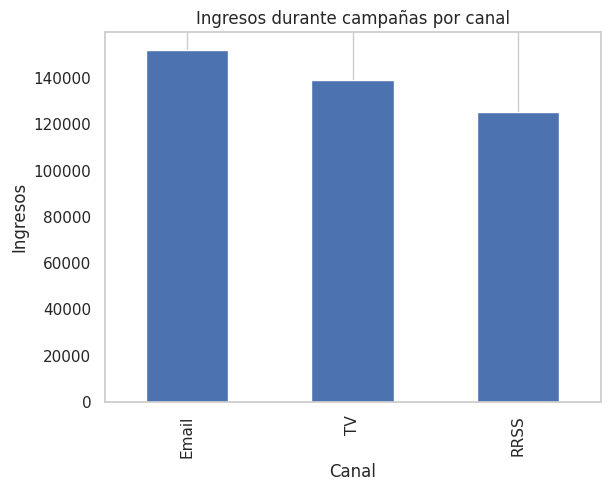

Guardado: /content/datasets/outputs/ventas_con_marketing.csv (utf-8-sig)


In [10]:

mk = marketing.copy()
mk["fecha_inicio"] = pd.to_datetime(mk["fecha_inicio"], dayfirst=True, errors="coerce")
mk["fecha_fin"]    = pd.to_datetime(mk["fecha_fin"],    dayfirst=True, errors="coerce")

ventas_mk = ventas.merge(mk, on="producto", how="left", suffixes=("", "_mk"))
mask_activa = (ventas_mk["fecha_venta"] >= ventas_mk["fecha_inicio"]) & (ventas_mk["fecha_venta"] <= ventas_mk["fecha_fin"])
ventas_mk["campania_activa"] = mask_activa.fillna(False)

act = ventas_mk[ventas_mk["campania_activa"]]
noact = ventas_mk[~ventas_mk["id_venta"].isin(act["id_venta"])] if "id_venta" in ventas_mk.columns else ventas_mk[~ventas_mk["campania_activa"]].drop_duplicates(subset=ventas.columns.tolist())
ventas_mk_one = pd.concat([act, noact], ignore_index=True)

efecto_camp = ventas_mk_one.groupby("campania_activa", as_index=False)["ingreso"].sum()
print("Ingresos con/ sin campaña activa:"); display(efecto_camp)

canal_perf = ventas_mk_one[ventas_mk_one["campania_activa"]].groupby("canal", as_index=False)["ingreso"].sum().sort_values("ingreso", ascending=False)
print("Ingresos por canal (campañas activas):"); display(canal_perf)

if not canal_perf.empty:
    plt.figure(); canal_perf.set_index("canal")["ingreso"].plot(kind="bar"); plt.title("Ingresos durante campañas por canal"); plt.xlabel("Canal"); plt.ylabel("Ingresos"); plt.grid(axis="y"); plt.show()

out2 = os.path.join(OUTPUTS_DIR, "ventas_con_marketing.csv")
ventas_mk_one.to_csv(out2, index=False, encoding="utf-8-sig")
print("Guardado:", out2, "(utf-8-sig)")



## 10) Integración con **clientes** (segmentación)
**Objetivo:** enriquecer ventas con atributos de clientes y segmentar por **edad**/**ciudad**.

**Pasos:**
- Si no hay `id_cliente` en ventas, crear asignación reproducible.
- `merge` con `clientes` y derivar `segmento_edad`.
- Resumir por **segmento** y **ciudad** (top 15).
- Exportar CSV (utf-8-sig).


Ingresos por segmento de edad:


,segmento_edad,ingreso
2,35-44,555497.50
1,25-34,492364.80
3,45-54,258096.90
0,<=24,82485.72
4,55-64,48831.21
5,65+,30752.34


Top 15 ciudades por ingreso:


,ciudad,ingreso
4,Mar del Plata,153110.91
6,Posadas,145234.85
8,Rosario,139135.28
7,Resistencia,132837.49
2,Corrientes,132671.10
11,Santa Fe,129228.69
5,Merlo,117427.49
3,Córdoba,115355.31
1,Buenos Aires,107031.94
9,Salta,103796.76


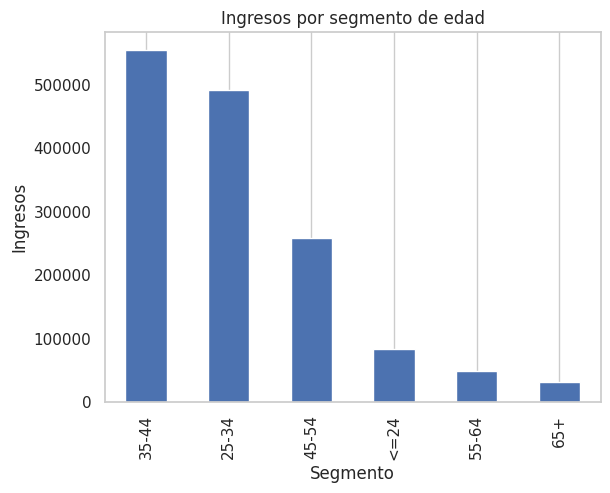

Guardado: /content/datasets/outputs/ventas_con_clientes.csv (utf-8-sig)


In [11]:

ventas_int = ventas.copy()
if "id_cliente" not in ventas_int.columns and "id_cliente" in clientes.columns:
    rng = np.random.default_rng(11)
    ventas_int["id_cliente"] = rng.choice(clientes["id_cliente"].values, size=len(ventas_int))

ventas_cli = ventas_int.merge(clientes, on="id_cliente", how="left")

bins = [0, 24, 34, 44, 54, 64, 120]
labels = ["<=24", "25-34", "35-44", "45-54", "55-64", "65+"]
ventas_cli["segmento_edad"] = pd.cut(ventas_cli["edad"], bins=bins, labels=labels, right=True, include_lowest=True)

resumen_segmentos = ventas_cli.groupby("segmento_edad", as_index=False)["ingreso"].sum().sort_values("ingreso", ascending=False)
resumen_ciudad    = ventas_cli.groupby("ciudad", as_index=False)["ingreso"].sum().sort_values("ingreso", ascending=False).head(15)

print("Ingresos por segmento de edad:"); display(resumen_segmentos)
print("Top 15 ciudades por ingreso:"); display(resumen_ciudad)

plt.figure(); resumen_segmentos.set_index("segmento_edad")["ingreso"].plot(kind="bar"); plt.title("Ingresos por segmento de edad"); plt.xlabel("Segmento"); plt.ylabel("Ingresos"); plt.grid(axis="y"); plt.show()

out3 = os.path.join(OUTPUTS_DIR, "ventas_con_clientes.csv")
ventas_cli.to_csv(out3, index=False, encoding="utf-8-sig")
print("Guardado:", out3, "(utf-8-sig)")



## 11) Calidad final (comparativa antes/después)
**Objetivo:** evidenciar mejora en duplicados/nulos tras limpieza.


In [12]:

resumen_calidad = pd.DataFrame({
    "dataset": ["ventas_raw", "ventas_limpias"],
    "filas": [len(ventas_raw), len(ventas)],
    "duplicados_filas": [int(ventas_raw.duplicated().sum()), int(ventas.duplicated().sum())],
    "nulos_totales": [int(ventas_raw.isna().sum().sum()), int(ventas.isna().sum().sum())]
})
display(resumen_calidad)


,dataset,filas,duplicados_filas,nulos_totales
0,ventas_raw,3035,35,4
1,ventas_limpias,3000,0,2



## 12) Export y descarga de resultados
Los archivos quedan en **`/content/datasets/outputs`** (alias **`/datasets/outputs`**):

- `productos_alto_rendimiento.csv`  
- `ventas_con_marketing.csv`  
- `ventas_con_clientes.csv`  



In [13]:

print("Outputs en:", OUTPUTS_DIR)
print(os.listdir(OUTPUTS_DIR))


Outputs en: /content/datasets/outputs
['ventas_con_clientes.csv', 'ventas_con_marketing.csv', 'productos_alto_rendimiento.csv']


## 13) Estadística descriptiva y correlación

**Objetivo:** calcular medidas de tendencia central y dispersión sobre las ventas y analizar la relación entre precio, cantidad e ingreso.

Trabajamos sobre el dataset limpio `ventas`, que ya contiene:

- `precio_num`: precio unitario numérico
- `cantidad`: cantidad vendida
- `ingreso`: `precio_num * cantidad`
- `fecha_venta`: fecha en formato `datetime`


Medidas descriptivas por variable:


,cantidad_registros,media,desvío_std,mínimo,p25,mediana,p75,máximo
ingreso,3000.0,489.342823,334.175457,26.3,221.08,418.065,709.4400,1488.12
precio_num,3000.0,75.288813,28.726878,26.0,50.05,75.205,100.0625,124.97
cantidad,3000.0,6.502667,3.453979,1.0,3.00,7.000,9.0000,12.00



Resumen mensual (ingreso y ticket medio):


,anio_mes,ingreso_total,cantidad_total,ticket_medio_mes
0,2024-01,130539.94,1754.0,74.424139
1,2024-02,118672.44,1607.0,73.847194
2,2024-03,136779.15,1792.0,76.327651
3,2024-04,128430.69,1715.0,74.886700
4,2024-05,143727.25,1812.0,79.319674
5,2024-06,108480.17,1426.0,76.073050
6,2024-07,116229.97,1547.0,75.132495
7,2024-08,119680.15,1614.0,74.151270
8,2024-09,115787.85,1576.0,73.469448
9,2024-10,112117.13,1458.0,76.897894



Matriz de correlación precio/cantidad/ingreso:


,precio_num,cantidad,ingreso
precio_num,1.000000,-0.002372,0.558858
cantidad,-0.002372,1.000000,0.773012
ingreso,0.558858,0.773012,1.000000


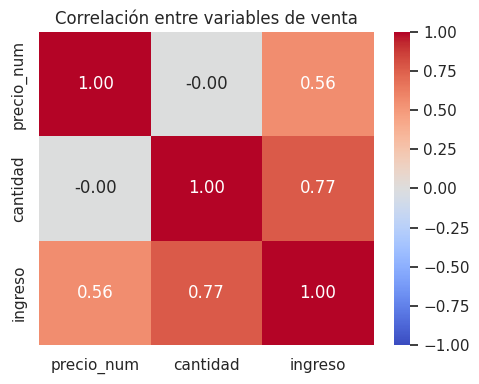

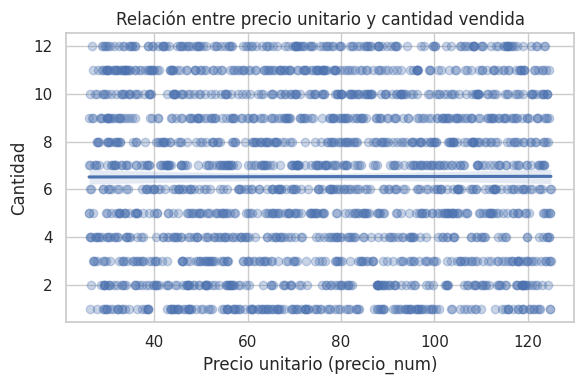

In [14]:
# 13) Estadística descriptiva y correlación

# --- Estadística descriptiva a nivel venta ---

cols_metricas = ["ingreso", "precio_num", "cantidad"]
metricas_venta = (
    ventas[cols_metricas]
    .describe()
    .T.rename(columns={
        "count": "cantidad_registros",
        "mean": "media",
        "std": "desvío_std",
        "min": "mínimo",
        "25%": "p25",
        "50%": "mediana",
        "75%": "p75",
        "max": "máximo"
    })
)

print("Medidas descriptivas por variable:")
display(metricas_venta)

# --- Estadística descriptiva mensual (ingresos y ticket medio) ---

if "anio_mes" in ventas.columns:
    resumen_mensual = (
        ventas
        .groupby("anio_mes", as_index=False)
        .agg(
            ingreso_total=("ingreso", "sum"),
            cantidad_total=("cantidad", "sum")
        )
    )
    resumen_mensual["ticket_medio_mes"] = (
        resumen_mensual["ingreso_total"] / resumen_mensual["cantidad_total"]
    )

    print("\nResumen mensual (ingreso y ticket medio):")
    display(resumen_mensual)

# --- Matriz de correlación ---

vars_corr = ["precio_num", "cantidad", "ingreso"]
corr = ventas[vars_corr].corr()

print("\nMatriz de correlación precio/cantidad/ingreso:")
display(corr)

plt.figure(figsize=(5, 4))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlación entre variables de venta")
plt.tight_layout()
plt.show()

# --- Scatter con regresión: precio vs cantidad ---

muestra = ventas.sample(min(2000, len(ventas)), random_state=42)

plt.figure(figsize=(6, 4))
sns.regplot(
    data=muestra,
    x="precio_num",
    y="cantidad",
    scatter_kws={"alpha": 0.3}
)
plt.title("Relación entre precio unitario y cantidad vendida")
plt.xlabel("Precio unitario (precio_num)")
plt.ylabel("Cantidad")
plt.tight_layout()
plt.show()


## 14) Dashboard interactivo con Plotly

**Objetivo:** construir un dashboard interactivo que combine varias vistas:

1. Ingresos por mes.
2. Ingresos por categoría.
3. Top 10 productos por ingreso.
4. Relación precio/cantidad coloreada por categoría.

Esto permite explorar el negocio de forma dinámica y visualizar patrones de forma integrada.


In [15]:
# 14) Dashboard interactivo con Plotly

# Agregados básicos (reusamos la estructura de ventas ya limpia)
ventas_mensuales_dash = (
    ventas
    .assign(anio_mes=ventas["fecha_venta"].dt.to_period("M").astype(str))
    .groupby("anio_mes", as_index=False)
    .agg(
        ingreso_total=("ingreso", "sum"),
        cantidad_total=("cantidad", "sum")
    )
)

cat_ingresos_dash = (
    ventas
    .groupby("categoria", as_index=False)["ingreso"]
    .sum()
    .sort_values("ingreso", ascending=False)
)

top_prod_dash = (
    ventas
    .groupby("producto", as_index=False)["ingreso"]
    .sum()
    .sort_values("ingreso", ascending=False)
    .head(10)
)

muestra_scatter = ventas.sample(min(3000, len(ventas)), random_state=42)

fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=(
        "Ingresos por mes",
        "Ingresos por categoría",
        "Top 10 productos por ingreso",
        "Precio vs cantidad (por categoría)"
    )
)

# 1) Línea mensual
fig_mes = px.line(
    ventas_mensuales_dash,
    x="anio_mes",
    y="ingreso_total"
)
for tr in fig_mes.data:
    fig.add_trace(tr, row=1, col=1)

# 2) Barras por categoría
fig_cat = px.bar(
    cat_ingresos_dash,
    x="categoria",
    y="ingreso"
)
for tr in fig_cat.data:
    fig.add_trace(tr, row=1, col=2)

# 3) Barras top productos
fig_prod = px.bar(
    top_prod_dash,
    x="producto",
    y="ingreso"
)
for tr in fig_prod.data:
    fig.add_trace(tr, row=2, col=1)

# 4) Scatter precio vs cantidad coloreado por categoría
fig_scatter = px.scatter(
    muestra_scatter,
    x="precio_num",
    y="cantidad",
    color="categoria",
    hover_data=["producto"]
)
for tr in fig_scatter.data:
    fig.add_trace(tr, row=2, col=2)

fig.update_layout(
    height=800,
    width=1100,
    title_text="Dashboard interactivo de ventas - SynthData",
    showlegend=True
)

fig.update_xaxes(title_text="Mes", row=1, col=1)
fig.update_yaxes(title_text="Ingresos", row=1, col=1)

fig.update_xaxes(title_text="Categoría", row=1, col=2)
fig.update_yaxes(title_text="Ingresos", row=1, col=2)

fig.update_xaxes(title_text="Producto", row=2, col=1)
fig.update_yaxes(title_text="Ingresos", row=2, col=1)

fig.update_xaxes(title_text="Precio unitario", row=2, col=2)
fig.update_yaxes(title_text="Cantidad", row=2, col=2)

fig.show()


## 15) Dataset final consolidado (ventas + clientes + marketing)

**Objetivo:** consolidar en un único dataset la información de ventas, clientes y campañas de marketing, para usarlo como base en la presentación y futuros modelos.

Partimos de:

- `ventas_cli`: ventas unidas con información de clientes.
- `ventas_mk_one`: ventas unidas con información de campañas (`campania_activa`, `canal`, `costo`, etc.).


In [16]:
# 15) Dataset final consolidado

# Columnas de marketing que nos interesan sumar al dataset final
cols_campania = ["id_venta", "campania_activa", "id_campanha", "canal", "costo"]
cols_campania = [c for c in cols_campania if c in ventas_mk_one.columns]

df_final = ventas_cli.merge(
    ventas_mk_one[cols_campania].drop_duplicates(subset=["id_venta"]),
    on="id_venta",
    how="left"
)

print("Shape dataset final (filas, columnas):", df_final.shape)
display(df_final.head())

out_final = os.path.join(OUTPUTS_DIR, "dataset_final_ventas_clientes_marketing.csv")
df_final.to_csv(out_final, index=False, encoding="utf-8-sig")
print("Guardado:", out_final)


Shape dataset final (filas, columnas): (3000, 19)


,id_venta,producto,precio,cantidad,fecha_venta,categoria,precio_num,ingreso,anio_mes,id_cliente,nombre,edad,ciudad,ingresos,segmento_edad,campania_activa,id_campanha,canal,costo
0,792,Cuadro decorativo,$69.94,5.0,2024-01-02,Decoración,69.94,349.70,2024-01,76,Fionnula Antoniutti,32,Corrientes,8756.53,25-34,False,1,RRSS,5.27
1,811,Lámpara de mesa,$105.10,5.0,2024-01-02,Decoración,105.10,525.50,2024-01,73,Clayborne Lipgens,33,Posadas,53758.89,25-34,False,32,Email,5.54
2,1156,Secadora,$97.96,3.0,2024-01-02,Electrodomésticos,97.96,293.88,2024-01,452,Dmitri Lucas,27,Bahía Blanca,50291.04,25-34,False,3,RRSS,5.10
3,1372,Heladera,$114.35,8.0,2024-01-02,Electrodomésticos,114.35,914.80,2024-01,284,Joanie Backler,69,Santa Fe,51581.12,65+,False,34,Email,4.20
4,1546,Secadora,$106.21,4.0,2024-01-02,Electrodomésticos,106.21,424.84,2024-01,335,Fin Arthan,25,Merlo,41383.85,25-34,False,3,RRSS,5.10


Guardado: /content/datasets/outputs/dataset_final_ventas_clientes_marketing.csv



---

**Conclusión**

**Performance general**

Ingresos totales del período: $1.468.028,47.

1) Categorias muy balanceadas por aporte:

- Electrodomésticos 34,4% · Electrónica 33,0% · Decoración 32,7%.

- Pico mensual: mayo 2024 ($143.727,25).
- Mes más bajo: junio 2024 ($108.480,17) → el pico supera al mínimo en +32,5%.

- Productos de alto rendimiento (p75): 8 ítems aportan 34,1% del total.

2) Top 5 por ingresos y aporte sobre el total:

- Lámpara de mesa 5,6%

- Auriculares 5,1%

- Microondas 4,9%

- Cafetera 4,1%

- Cuadro decorativo 3,7%

3) Marketing (campañas)

- Se depuraron ventas con múltiples líneas de campaña para dejar 1 fila por id_venta (priorizando campañas activas). Tras limpiar: 3.000 ventas totales, 25,6% ocurrieron con campaña activa.

- Ingresos con campaña activa: 26,0% del total.

- Ticket medio con campaña vs. sin: +2,0% (496,70 vs. 486,81).
Uplift modesto: sugiere que las campañas empujan volumen pero sólo mejoran levemente el valor por venta.

- Rendimiento por canal (sólo ventas con campaña):

- Email: 36,7% del ingreso de campañas (ticket medio ≈ 499,47).

- TV: 33,0% (ticket medio ≈ 503,74) —el ticket más alto.

- RRSS: 30,3% (ticket medio ≈ 486,05).

- Lectura: Email y TV concentran 7 de cada 10 pesos de campañas; TV logra el ticket medio más alto.

4) Clientes (segmentación)

- Por edad (participación de ingresos):

- 35–44: 37,8% (ticket medio ≈ 483,46)

- 25–34: 33,5% (ticket medio ≈ 492,86)

- 45–54: 17,6% (ticket medio ≈ 503,11)

- <=24: 5,6% · 55–64: 3,3% · 65+: 2,1% (ticket más alto ≈ 530,21, aunque volumen chico)

- Lectura: 71% del ingreso está entre 25–44; 45–54 - tiene buen ticket; 65+ compra poco pero caro.

- Top 10 ciudades concentran ≈86,9% del ingreso.
- Top 3: Mar del Plata (10,4%), Posadas (9,9%), Rosario (9,5%).
CABA aporta 7,3% con ticket alto (~504,87).

5) Oportunidades y acciones recomendadas

- Doble foco en 25–44

- Creatividades y bundles pensados para uso cotidiano (electro + deco) y accesorios electrónicos (auriculares, lámparas, microondas).

- Remarketing específico a este rango: es el 70% del ingreso.

- Optimizar el mix de canales

- Mantener Email por costo/eficiencia y TV por ticket medio (test A/B de mensajes y horarios para TV).

- En RRSS, probar formatos de conversión (catálogo dinámico / ofertas flash) para elevar ticket medio.

- Potenciar top-products

- Promos “gancho” con Lámpara de mesa y Auriculares; cross-sell con Cafetera y Microondas (combos cocina).

- Reponer stock y asegurar precios competitivos de los 8 alto rendimiento (aportan 34,1%).

- Geosegmentación

- Campañas dedicadas para Mar del Plata, Posadas, Rosario; ajustar logística y promesas de entrega en esas plazas.

- CABA: mantener inversión por ticket alto; test premium/upsell.

- Calendario comercial

- Replicar táctica de mayo (pico del año) y corregir junio (bache) con acciones previas (pre-campañas 10–14 días antes, cupones escalonados).

- Métrica de control

- Seguir ticket medio por canal y % de ventas bajo campaña semana a semana.

- Medir uplift incremental (A/B holdout) para saber el verdadero aporte de cada campaña.
